<a href="https://colab.research.google.com/github/jtrummler/MUSA650_Final/blob/main/MUSA650_final_keel_rummler_tanabe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of Hurricane Damage

Damage assessment after a natural disaster is a critical step in emergency response efforts. It allows responders to determine the scale of damage, allocate resources efficiently, and identify areas and communities in need of assistance. Damage assessments also help responders understand the degree of structural loss, the number of people displaced who need temporary housing, and the state of natural resources in the area. Overall, accurate and reliable damage assessments are key to informing response to natural disasters.

Traditionally, damage assessment is done by ground survey which relies on resources that are often limited after a disaster. A physical damage assessment requires a large amount of time, access to transportation systems, and additional resources and logistics to support a team of assessors traveling to the area. However, remote sensing has facilitated more resource efficient assessments following a disaster. Remote sensing tools can now be used to detect damage, predict future damage, and analyze total loss. These tools can use geospatial techniques to identify coordinate locations of real-time imagery to determine immediate needs in exact places. This data can also be used after a disaster event to classify the extent of damage and identify patterns to better prepare communities in the future.

## Loading Data

Within the directory there are four folders we're importing:

**train_another** : the training data; 5000 images of each class

**validation_another**: the testidation data; 1000 images of each class

**test_another** : the unbalanced test data; 8000/1000 images of damaged/undamaged classes

**test** : the balanced test data; 1000 images of each class

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from matplotlib.pyplot import imread, imshow, subplots, show
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics

In [ ]:
#Testing a single image's shape to determine number of channels to import
import skimage as skimage
import os as os

tr_path = 'D:/MUSA/MUSASpring/M650_Sensing/data_hurricane/train_another/damage/-93.6141_30.754263.jpeg'

image_test = skimage.io.imread(tr_path)

image_test.shape

(128, 128, 3)

#### Training Set Import

In [ ]:
#Since the channels are 3, we can use keras to import into a dataset.
tr_path = 'D:/MUSA/MUSASpring/M650_Sensing/data_hurricane/train_another/'

#Use Keras to import data
tr_dataset = keras.utils.image_dataset_from_directory(
    tr_path,
    labels="inferred",
    label_mode="int",
    class_names= ['no_damage', 'damage'],
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

#Convert keras dataset to numpy array
tr_dataset = tr_dataset.unbatch()
tr_images = np.asarray(list(tr_dataset.map(lambda x, y: x)))
tr_labels = np.asarray(list(tr_dataset.map(lambda x, y: y)))


Found 10000 files belonging to 2 classes.


0: No Damage

1: Damage

0


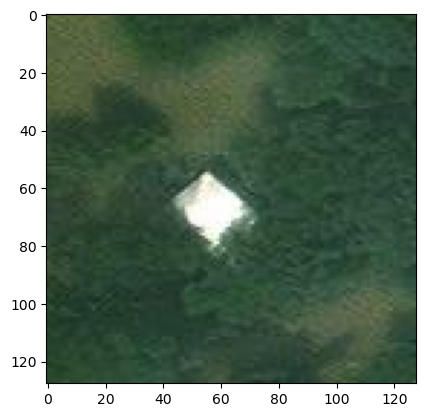

In [ ]:
plt.imshow(tr_images[0].astype('uint8'))
print(tr_labels[5000])

The above image is in the damage folder as "-93.55964_30.895018", so the import is labeling them correctly.

#### Validation Set Import

In [ ]:
#Since the channels are 3, we can use keras to import into a dataset.
val_path = 'D:/MUSA/MUSASpring/M650_Sensing/data_hurricane/validation_another/'

#Use Keras to import data
val_dataset = keras.utils.image_dataset_from_directory(
    val_path,
    labels="inferred",
    label_mode="int",
    class_names= ['no_damage', 'damage'],
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

#Convert keras dataset to numpy array
val_dataset = val_dataset.unbatch()
val_images = np.asarray(list(val_dataset.map(lambda x, y: x)))
val_labels = np.asarray(list(val_dataset.map(lambda x, y: y)))

Found 2000 files belonging to 2 classes.


#### Testing Set Import

There are two test sets for this data, one with imbalanced data (another_test) and one with balanced (test). 

These will be kept for final testing.

In [ ]:
#Since the channels are 3, we can use keras to import into a dataset.
test_path = 'D:/MUSA/MUSASpring/M650_Sensing/data_hurricane/test/'

#Use Keras to import data
test_dataset = keras.utils.image_dataset_from_directory(
    test_path,
    labels="inferred",
    label_mode="int",
    class_names= ['no_damage', 'damage'],
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

#Convert keras dataset to numpy array
test_dataset = test_dataset.unbatch()
test_images = np.asarray(list(test_dataset.map(lambda x, y: x)))
test_labels = np.asarray(list(test_dataset.map(lambda x, y: y)))

Found 2000 files belonging to 2 classes.


In [ ]:
#Since the channels are 3, we can use keras to import into a dataset.
testPlus_path = 'D:/MUSA/MUSASpring/M650_Sensing/data_hurricane/test_another/'

#Use Keras to import data
testPlus_dataset = keras.utils.image_dataset_from_directory(
    testPlus_path,
    labels="inferred",
    label_mode="int",
    class_names= ['no_damage', 'damage'],
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

#Convert keras dataset to numpy array
testPlus_plus_dataset = testPlus_dataset.unbatch()
testPlus_images = np.asarray(list(testPlus_dataset.map(lambda x, y: x)))
testPlus_labels = np.asarray(list(testPlus_dataset.map(lambda x, y: y)))

Found 9000 files belonging to 2 classes.


C:\Users\Beeel\AppData\Local\Temp\ipykernel_29012\1909265154.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  testPlus_images = np.asarray(list(testPlus_dataset.map(lambda x, y: x)))
C:\Users\Beeel\AppData\Local\Temp\ipykernel_29012\1909265154.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  testPlus_labels = np.asarray(list(testPlus_dataset.map(lambda x, y: y)))


### Preprocessing Images

We could add more data if we wanted to process via zoom, rotate, etc and add more images?

## Model 1: CNN

We will develop our own CNN model using convolutional layers and fully connected layers, while incorporating other layers such as batch normalization, dropout, flattening, and others to help normalize the data

In [ ]:
#Split train data into train and test

x_tr_train, x_tr_test, y_tr_train, y_tr_test = train_test_split(tr_images, tr_labels, test_size=0.5, random_state=0)

In [ ]:
y_tr_test.shape

(5000,)

In [ ]:
#convert labels to binary class matrices
y_tr_train = to_categorical(y_tr_train)
y_tr_test = to_categorical(y_tr_test)

val_labels_cat = to_categorical(val_labels)

In [ ]:
#Using a data generator to help batch the data

from keras.utils import Sequence
import numpy as np   

#Taken from https://stackoverflow.com/questions/62916904/failed-copying-input-tensor-from-cpu-to-gpu-in-order-to-run-gatherve-dst-tensor
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y


In [ ]:
#Data split from training data
train_tr_gen = DataGenerator(x_tr_train, y_tr_train, 32)
test_tr_gen = DataGenerator(x_tr_test, y_tr_test, 32)

#Data split from validation data
val_gen = DataGenerator(val_images, val_labels_cat, 32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 2)       56        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 2)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 2)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 16,442
Trainable params: 16,442
Non-trainable params: 0
____________________________________________________

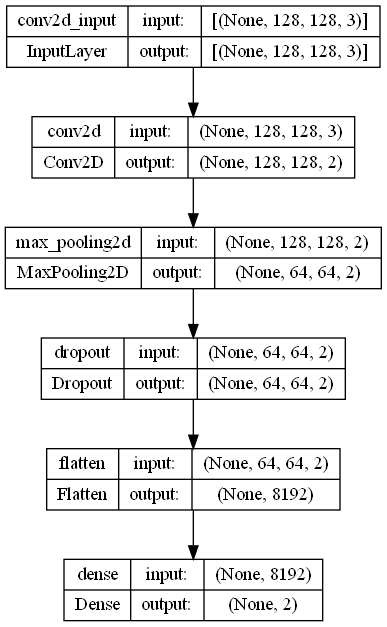

In [ ]:
#Compile model with Conv2D, MaxPooling2D, Dropout, Flatten, and Dense layers

from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Dense
from keras.utils import plot_model

CNN_1 = Sequential()
CNN_1.add(Conv2D(input_shape=(128,128,3), filters=2, kernel_size=(3, 3), padding = 'same', activation='relu'))
CNN_1.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
CNN_1.add(Dropout(0.25))
CNN_1.add(Flatten())
CNN_1.add(Dense(2, activation='softmax'))

#summarize model
CNN_1.summary()

#plot model
plot_model(CNN_1, to_file='model-plot_CNN_1.png', show_shapes=True, show_layer_names=True)

In [ ]:
#compile model
CNN_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#fit model
history1 = CNN_1.fit(train_tr_gen, epochs=25, batch_size=16, validation_data=(test_tr_gen))

Epoch 1/25
157/157 [==============================] - 8s 15ms/step - loss: 11.8859 - accuracy: 0.5666 - val_loss: 1.3104 - val_accuracy: 0.6806
Epoch 2/25
157/157 [==============================] - 2s 12ms/step - loss: 1.0986 - accuracy: 0.6864 - val_loss: 1.1512 - val_accuracy: 0.7324
Epoch 3/25
157/157 [==============================] - 2s 12ms/step - loss: 0.6137 - accuracy: 0.7754 - val_loss: 1.1388 - val_accuracy: 0.7306
Epoch 4/25
157/157 [==============================] - 2s 13ms/step - loss: 0.5015 - accuracy: 0.8026 - val_loss: 1.1733 - val_accuracy: 0.7502
Epoch 5/25
157/157 [==============================] - 2s 13ms/step - loss: 0.4591 - accuracy: 0.8302 - val_loss: 1.2880 - val_accuracy: 0.7716
Epoch 6/25
157/157 [==============================] - 2s 13ms/step - loss: 0.4555 - accuracy: 0.8286 - val_loss: 1.6106 - val_accuracy: 0.7952
Epoch 7/25
157/157 [==============================] - 2s 13ms/step - loss: 0.4202 - accuracy: 0.8562 - val_loss: 1.1282 - val_accuracy: 0.701

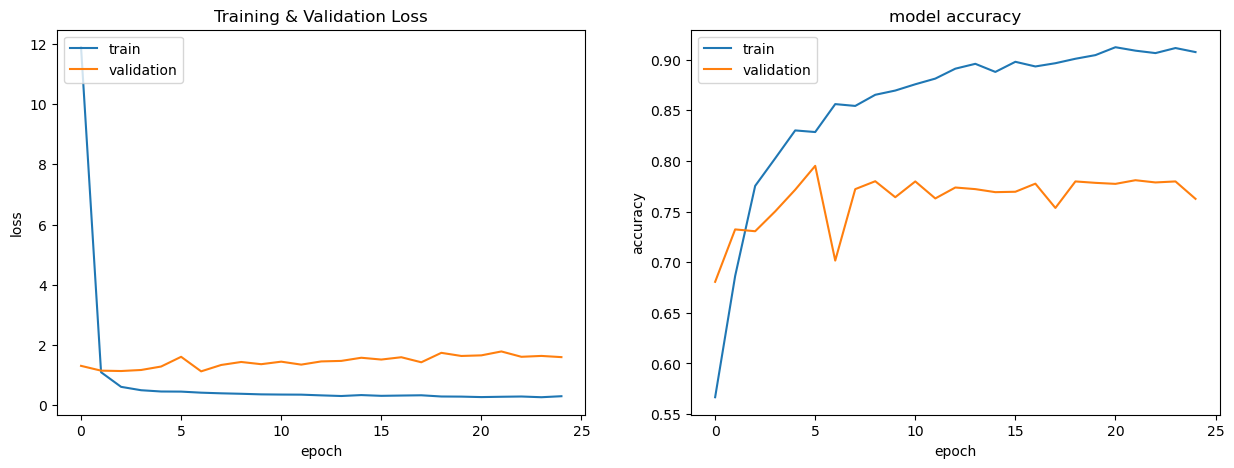

Test loss: 1.6308714151382446
Test accuracy: 0.7684999704360962


In [ ]:
#Plot both loss and accuracy in subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(history1.history['loss'])
ax1.plot(history1.history['val_loss'])
ax1.set_title('Training & Validation Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(history1.history['accuracy'])
ax2.plot(history1.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
plt.show()

#accuracy of model
score1 = CNN_1.evaluate(val_gen, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

### Improving the model

This basic model has lower accuracy and overfits to the test data, as you can see in the increasing loss over time for the validation set. We'll try to improve it through more normalization and adding filters to get certain signals.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 2)       56        
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 2)      8         
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 2)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 2)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 4)         76        
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 4)       

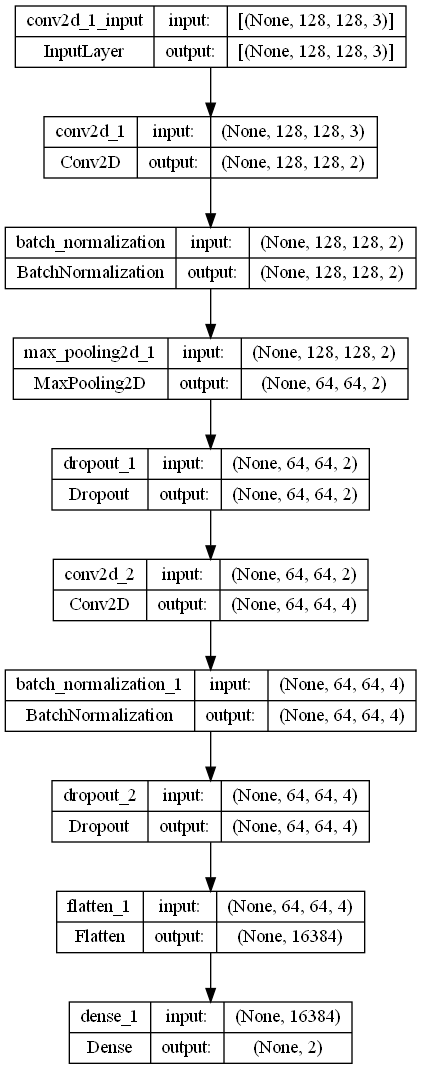

In [ ]:
CNN_2 = Sequential()
CNN_2.add(Conv2D(input_shape=(128,128,3), filters=2, kernel_size=(3, 3), padding = 'same', activation='relu'))
CNN_2.add(BatchNormalization())
CNN_2.add(MaxPooling2D(pool_size=(2, 2)))   
CNN_2.add(Dropout(0.25))
CNN_2.add(Conv2D(input_shape=(64,64,3), filters=4, kernel_size=(3, 3), padding = 'same', activation='relu'))
CNN_2.add(BatchNormalization())
CNN_2.add(Dropout(0.25))
CNN_2.add(Flatten())
CNN_2.add(Dense(2, activation='softmax'))

#summarize model
CNN_2.summary()

#plot model
plot_model(CNN_2, to_file='model-plot_CNN_2.png', show_shapes=True, show_layer_names=True)

In [ ]:
#compile model
CNN_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#fit model
history2 = CNN_2.fit(train_tr_gen, epochs=25, batch_size=16, validation_data=(test_tr_gen))

Epoch 1/25
157/157 [==============================] - 3s 16ms/step - loss: 0.5375 - accuracy: 0.7872 - val_loss: 0.5842 - val_accuracy: 0.7648
Epoch 2/25
157/157 [==============================] - 2s 16ms/step - loss: 0.4393 - accuracy: 0.8224 - val_loss: 0.6033 - val_accuracy: 0.7818
Epoch 3/25
157/157 [==============================] - 2s 15ms/step - loss: 0.3772 - accuracy: 0.8516 - val_loss: 0.6539 - val_accuracy: 0.7908
Epoch 4/25
157/157 [==============================] - 2s 15ms/step - loss: 0.3461 - accuracy: 0.8658 - val_loss: 0.6242 - val_accuracy: 0.8020
Epoch 5/25
157/157 [==============================] - 2s 15ms/step - loss: 0.3003 - accuracy: 0.8818 - val_loss: 0.6927 - val_accuracy: 0.7608
Epoch 6/25
157/157 [==============================] - 2s 15ms/step - loss: 0.2779 - accuracy: 0.8976 - val_loss: 0.6409 - val_accuracy: 0.8122
Epoch 7/25
157/157 [==============================] - 2s 15ms/step - loss: 0.2544 - accuracy: 0.9022 - val_loss: 0.6555 - val_accuracy: 0.8038

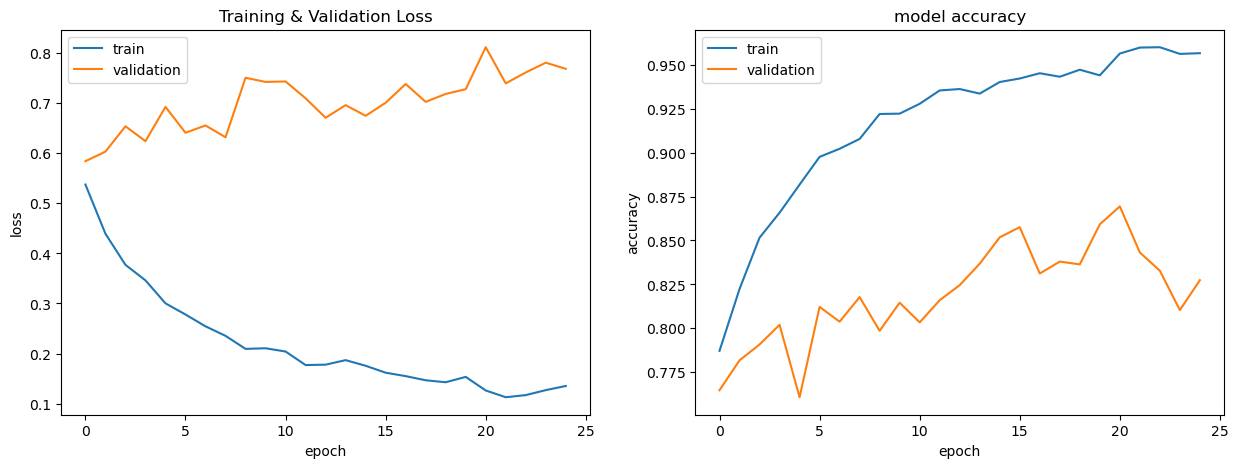

Test loss: 0.7692603468894958
Test accuracy: 0.8230000138282776


In [ ]:
#Plot both loss and accuracy in subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(history2.history['loss'])
ax1.plot(history2.history['val_loss'])
ax1.set_title('Training & Validation Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(history2.history['accuracy'])
ax2.plot(history2.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
plt.show()

#accuracy of model
score2 = CNN_2.evaluate(val_gen, verbose=0)
print('Test loss:', score2[0])
print('Test accuracy:', score2[1])

### Data Augmentation

Using BatchNormalization() helped reduce the diverging loss of the data sets. Two other methods available to us are data augmentation and weight regularization

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from matplotlib.pyplot import imread, imshow, subplots, show

#Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.2,
    fill_mode='nearest')

datagen.fit(x_tr_train)

In [ ]:
#Data and labels from training set into data generator for batching memory
#aug_tr_train = DataGenerator(datagen, y_tr_train, 32)

#fit model to augmented data
history3 = CNN_2.fit(datagen.flow(x_tr_train, y_tr_train), epochs=25, batch_size=16, validation_data=(test_tr_gen))

Epoch 1/25
157/157 [==============================] - 19s 121ms/step - loss: 0.4980 - accuracy: 0.8086 - val_loss: 0.5045 - val_accuracy: 0.7888
Epoch 2/25
157/157 [==============================] - 19s 120ms/step - loss: 0.4411 - accuracy: 0.8394 - val_loss: 0.3413 - val_accuracy: 0.8796
Epoch 3/25
157/157 [==============================] - 19s 118ms/step - loss: 0.4358 - accuracy: 0.8270 - val_loss: 0.5517 - val_accuracy: 0.8166
Epoch 4/25
157/157 [==============================] - 18s 117ms/step - loss: 0.4293 - accuracy: 0.8428 - val_loss: 0.3567 - val_accuracy: 0.8570
Epoch 5/25
157/157 [==============================] - 18s 116ms/step - loss: 0.3928 - accuracy: 0.8486 - val_loss: 0.3271 - val_accuracy: 0.8722
Epoch 6/25
157/157 [==============================] - 19s 118ms/step - loss: 0.3999 - accuracy: 0.8396 - val_loss: 0.3170 - val_accuracy: 0.8884
Epoch 7/25
157/157 [==============================] - 19s 119ms/step - loss: 0.3753 - accuracy: 0.8602 - val_loss: 0.3227 - val_ac

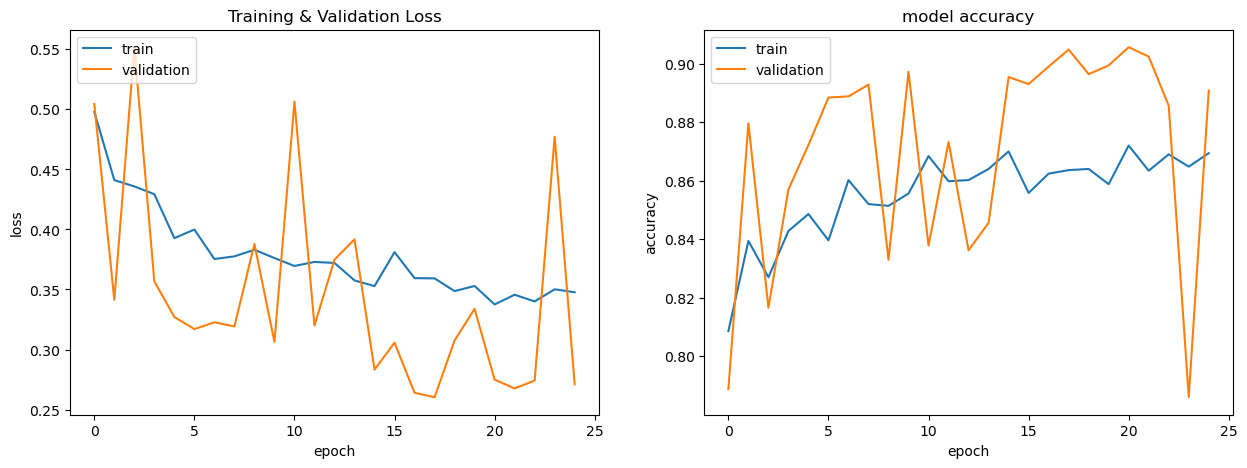

Test loss: 0.27099061012268066
Test accuracy: 0.8970000147819519


In [ ]:
#Plot both loss and accuracy in subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(history3.history['loss'])
ax1.plot(history3.history['val_loss'])
ax1.set_title('Training & Validation Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(history3.history['accuracy'])
ax2.plot(history3.history['val_accuracy'])
ax2.set_title('model accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
plt.show()

#accuracy of model
score3 = CNN_2.evaluate(val_gen, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

The CNN model started simply with one convolution layer as a benchmark for the data. and performed better than a coin-flip at 70% when tested against the validation set. However, the model is evidently overfit and continues to overfit with more epochs, and the accuracy can be improved. We improved the model's accuracy by adding an additional convolution layer and more filters, and improved its generalizability by adding Batch Normalization layers after each convolution. However, there was still a gap between the training set and the validation set, meaning the model was not generalizing as well as it could. Our most recent step was to add image augmentation to the training set. The images in the training set may be framed differently on average than the ones in the validation set, with the houses at different zoom levels or from certain angles. Adding rotation and zoom augmentations to the image has now made the validation set test perform a couple percentage points better, so the model has been made more generalizable.

Next step is to improve the overall accuracy by adding more filters, convolutions, or hidden layers.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 4)       112       
                                                                 
 batch_normalization_7 (Batc  (None, 128, 128, 4)      16        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 4)        0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 4)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 4)         148       
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 4)       

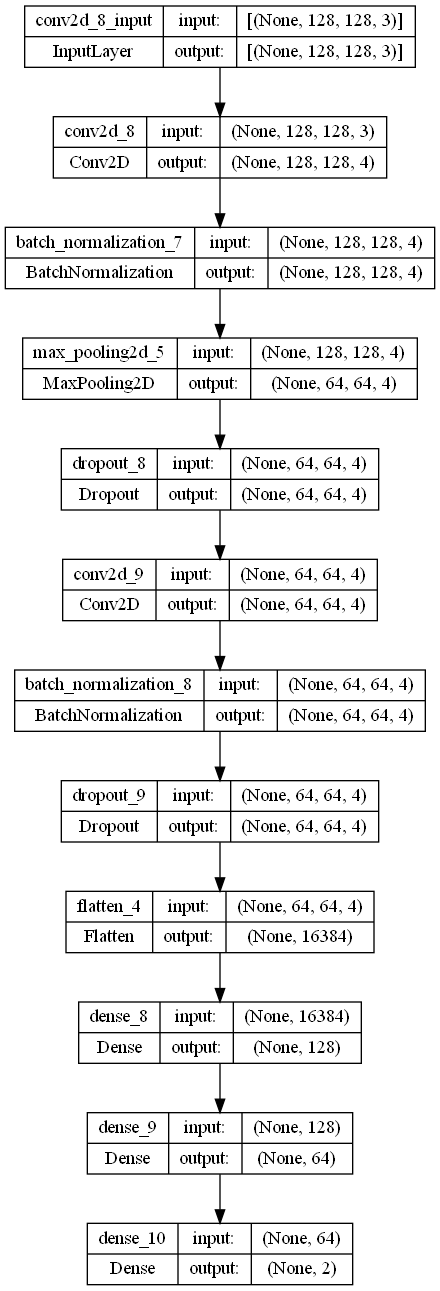

In [ ]:
CNN_3 = Sequential()
CNN_3.add(Conv2D(input_shape=(128,128,3), filters=8, kernel_size=(3, 3), padding = 'same', activation='relu'))
CNN_3.add(BatchNormalization())
CNN_3.add(MaxPooling2D(pool_size=(2, 2)))   
CNN_3.add(Dropout(0.25))
CNN_3.add(Conv2D(input_shape=(64,64,3), filters=8, kernel_size=(3, 3), padding = 'same', activation='relu'))
CNN_3.add(BatchNormalization())
CNN_3.add(Dropout(0.25))
CNN_3.add(Flatten())
CNN_3.add(Dense(64, activation='relu'))
CNN_3.add(Dense(2, activation='softmax'))

#summarize model
CNN_3.summary()

#plot model
plot_model(CNN_3, to_file='model-plot_CNN_3.png', show_shapes=True, show_layer_names=True)

## Model 2: Transfer Learning

Model 2: Transfer Learning with VGG16
Next, we will implement a transfer learning technique and apply a pre-trained model to our dataset. We are using VGG16 here.

In [ ]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.utils import plot_model

# loading VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# freezin layers from pre-trained model
for layer in vgg16.layers:
    layer.trainable = False

# adding a few other layers just in case
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

# creating model
model = Model(inputs=vgg16.input, outputs=predictions)

# compiling model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
plot_model(model, 
    show_shapes=True, 
    show_layer_names=True
)

In [ ]:
#fitting the model
history2 = model.fit(
    x_tr_train, y_tr_train,
    epochs=10, batch_size=16,
    validation_data=(x_tr_test, y_tr_test),
    verbose=1
)

In [ ]:
#accuracy of model
score1 = model.evaluate(x_tr_test, y_tr_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

#Plot both loss and accuracy in subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(history2.history['loss'])
ax1.plot(history2.history['val_loss'])
ax1.set_title('Training & Validation Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(history2.history['accuracy'])
ax2.plot(history2.history['val_accuracy'])
ax2.set_title('Training & Validation Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(x_tr_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# get the true class labels for test data
y_true_classes = np.argmax(y_tr_test, axis=1)

In [ ]:
# find an index of a correct prediction
correct_idx1 = np.where((y_pred_classes == 0) & (y_true_classes == 0))[0][0]
correct_idx2 = np.where((y_pred_classes == 1) & (y_true_classes == 1))[0][1]

# find an index of an incorrect prediction
incorrect_idx1 = np.where((y_pred_classes == 0) & (y_true_classes == 1))[0][0]
incorrect_idx2 = np.where((y_pred_classes == 1) & (y_true_classes == 0))[0][0]

# plot the correct prediction
plt.imshow(x_tr_test[correct_idx1].astype('uint8'))
plt.title("True Label: No Damage | Predicted Label: No Damage")
plt.show()
                        
# plot the correct prediction
plt.imshow(x_tr_test[correct_idx2].astype('uint8'))
plt.title("True Label: Damage | Predicted Label: Damage")
plt.show()

# plot the incorrect prediction
plt.imshow(x_tr_test[incorrect_idx1].astype('uint8'))
plt.title("True Label: No Damage | Predicted Label: Damage")
plt.show()
                        
# plot the incorrect prediction
plt.imshow(x_tr_test[incorrect_idx2].astype('uint8'))
plt.title("True Label: Damage | Predicted Label: No Damage")
plt.show()

We also started a transfer learning approach which implements a deep learning VGG16 model. Transfer learning allows us to build high-performance models for image classification by using models that have been previously trained on large dataset. We loaded the VGG16 model via Keras and leveraged the layers from the pre-trained model. We also added additional classification layers on top of the pre-trained mode in hopes of increasing the overall accuracy. So far, this method has been very successful. It has exceptionally high accuracy while running the epochs and an overall test accuracy rate of 0.93. However, we do run the risk of overfitting this model. we will consider different ways to reduce overfitting, including adding more dropout layers or implementing a variety of transformation methods, as we work through the rest of the project.

## Model 3: ResNet

Our final model is a residual neural network, which is an iteration of a convolutional neural network.

In [ ]:
img_width = 128
img_height = 128
num_channels = 3
num_classes = 2
input_shape = 128, 128, 3

In [ ]:
# Shapes of each label
from keras.utils import to_categorical
tr_y = to_categorical(train_y, num_classes=2)
v_y = to_categorical(val_y, num_classes=2)
te_y = to_categorical(test_y, num_classes=2)
print("Shape of train images is: ", train_X.shape)
print("Shape of validation images is: ", val_X.shape)
print("Shape of test images is: ", test_X.shape)
print("Shape of train labels is: ", tr_y.shape)
print("Shape of validation labels is: ", v_y.shape)
print("Shape of test labels is: ", te_y.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, ReLU, Add, Flatten, Dense
from tensorflow.keras.models import Model

def resnet_block(input_data, filters, strides=1):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding="same")(input_data)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = input_data
    if strides > 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)
    x = resnet_block(x, 512)

    x = Flatten()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

model = build_resnet(input_shape=(128, 128, 3), num_classes=num_classes)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_X, tr_y, batch_size=32, epochs=10, validation_data=(val_X, v_y))

In [ ]:
model = build_resnet(input_shape=(128, 128, 3), num_classes=num_classes)


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_X, tr_y, batch_size=32, epochs=10, validation_data=(val_X, v_y))


In [ ]:
# Apply to test data
loss, accuracy = model.evaluate(test_X, te_y)
# Print loss and accuracy scores rounded to 2 decimal places
print("Test Loss:", round(loss,2))
print("Test Accuracy:", round(accuracy,2))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, ReLU, Add, Flatten, Dense
from tensorflow.keras.models import Model

def resnet_block(input_data, filters, strides=1):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding="same")(input_data)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding="same")(x)
    x = BatchNormalization()(x)

    shortcut = input_data
    if strides > 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding="same")(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)
    x = resnet_block(x, 512)

    x = Flatten()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

model = build_resnet(input_shape=(128, 128, 3), num_classes=num_classes)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_X, tr_y, batch_size=32, epochs=10, validation_data=(val_X, v_y))

In [ ]:
# Apply to test data
loss, accuracy = model.evaluate(test_X, te_y)
# Print loss and accuracy scores rounded to 2 decimal places
print("Test Loss:", round(loss,2))
print("Test Accuracy:", round(accuracy,2))

In [ ]:

#Plot both loss and accuracy in subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Training & Validation Loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Training & Validation Model Accuracy')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='ResNetmodel.png', show_shapes=True, rankdir='TB', dpi=50)